In [1]:
#install the required libraries for the first time 
#e.g.
#pip install numpy 
#or 
#conda install anaconda::numpy

import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy 
import scipy.optimize

from astropy.modeling import models, fitting
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astroquery.vizier import Vizier

# Make plots display in notebooks
%matplotlib inline 

from IPython.display import HTML

## Κηφείδες αστέρες τύπου 2 (Type 2 Cepheids)

Οι Κηφείδες αστέρες τύπου 2 είναι χαμηλής μάζας αστέρες ($\sim 0.5 M_\odot$) με χαμηλή μεταλλικότητα και βρίσκονται συνήθως σε σφαιρωτά αστρικά σμήνη στο Γαλαξιακό δίσκο και στη Γαλαξιακή άλω. Οι τύπου 2 Κηφείδες είναι πιο αμυδροί από τους Κλασσικούς ή Τύπου 1 Κηφείδες με παρόμοιες ωστόσο περιόδους ανάπαλσης. Η περίοδος ανάπαλσης και η φωτεινότητα των άστρων αυτών συσχετίζονται αλλά ακολουθούν διαφορετική σχέση περιόδου-φωτεινότητας από τους Κλασσικούς Κηφείδες (βλ. Σχήμα). Η διαφοροποίηση σε 2 τύπους έγινε μόλις το 1952 από τον Walter Baade.

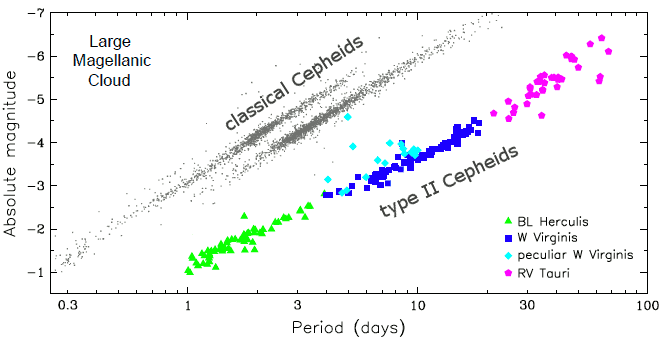

Σχήμα 1. Συσχέτιση απόλυτου μεγέθους - περιόδου για κλασσικούς Κηφείδες (γκρι σημεία) και Κηφείδες τύπου 2 (χρωματιστά σημεία) που ανήκουν στο Μεγάλο Νέφος του Μαγγελάνου. Οι Κηφείδες τύπου 2 διακρίνονται σε 3 υποκατηγορίες όπως φαίνεται από τα διαφορετικά χρώματα (Πίστωση εικόνας https://ogle.astrouw.edu.pl/atlas/type_II_Cepheids.html).

In [2]:
V = Vizier(row_limit=-1) # downloads all data from catalog -- default is 50
catstring = "J/A+A/605/A100"
catalog = V.get_catalogs('J/A+A/605/A100') # Publication info
cepheids = catalog[0]

In [3]:
catalog

TableList with 1 tables:
	'0:J/A+A/605/A100/table1' with 16 column(s) and 264 row(s) 

Αυτός ο κατάλαγος περιέχει πολλές πληροφορίες (βλ. ονόματα στηλών του πίνακα).

In [4]:
# check the headers of the table columns 
cepheids.columns

<TableColumns names=('VVV-ID','OGLE-ID','Period','Class','__Vmag_','__Imag_','__Jmag_','__Hmag_','__Ksmag_','e__Jmag_','e__Hmag_','e__Ksmag_','E_J-Ks_','Simbad','_RA','_DE')>

Απεικόνιση θέσης άστρων σε σύστημα γαλαξιακών συντεταγμένων. Για το σκοπό αυτό θα χρειαστείτε να διαβάσετε τις συντεταγμένες των άστρων από τον κατάλογο σε 'RA', 'DEC' και στη συνέχεια να της μετατρέψετε σε γαλαξιακές $(l,b)$.

In [5]:
c = SkyCoord(catalog[0]['_RA'], catalog[0]['_DE'], unit=(u.deg, u.deg))
c_gal = c.galactic # converts to galactic coordinate system
# print(c)
# print(c_gal)

# create a new variable where the longitudes > 180 degrees are shifted by 360 degrees.
l_deg = copy.deepcopy(c_gal.l)
l_deg.value[l_deg.value > 180.] -= 360
b_deg = copy.deepcopy(c_gal.b) 

### Διαγράμματα απεικόνισης θέσεων Κηφείδων.

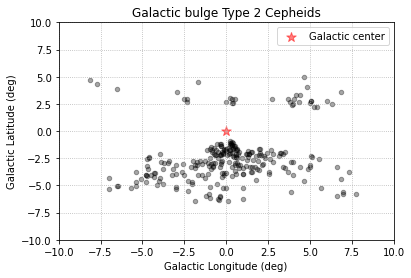

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(l_deg, b_deg, s=20, color='black', alpha=0.35)
ax.scatter(0, 0, s=100, color='red', marker='*', alpha=0.5, label = 'Galactic center') 
ax.set_xlim(-10., 10.)
ax.set_ylim(-10., 10.)
ax.grid(ls = ":")
ax.set_xlabel("Galactic Longitude (deg)")
ax.set_ylabel("Galactic Latitude (deg)")
ax.set_title('Galactic bulge Type 2 Cepheids')
ax.legend()
plt.show()

**Ερώτηση**: για ποιό λόγο κάναμε το shift στη συντεταγμένη $l$;

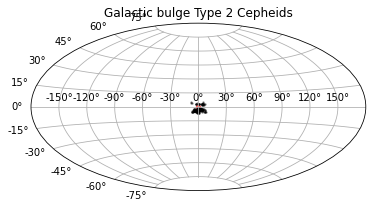

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='aitoff') 
# the coordinates need to be inputed in radians for this projection
ax.scatter(0, 0, s=20, color='red', marker='o', alpha=0.5, label = 'Galactic center') 
ax.scatter(l_deg*np.pi/180., b_deg*np.pi/180., s=2, color='black', alpha=0.35)
ax.set_title('Galactic bulge Type 2 Cepheids')
ax.grid()
plt.show()

### Άσκηση 

1. Να κατασκευάσετε το διάγραμμα μεγέθους-περιόδου των Κηφείδων του καταλόγου (με σφάλματα στα μεγέθη). Για το σκοπό αυτό θα χρειαστείτε να διαβάσετε τις στήλες του πίνακα 'Period' (days), 'Ksmag' (μέγεθος στο φίλτρο Ks), 'e_Ksmag' (σφάλμα μέτρηση μεγέθους Ks) και να κατασκευάσετε ένα διάγραμμα. Τι είδους άξονες θα επιλέγατε (π.χ. λογαριθμικό ή γραμμικό) για τη βέλτιστη αναπαράσταση; 


2. Η σχέση απόλυτου μεγέθους - περιόδου των Κηφείδων είναι της μορφής $M_i= a [\log_{10}(P) - p ] + b$. Για κλασσικούς Κηφείδες του Γαλαξία μας στο φίλτρο $V$ έχει βρεθεί ότι $a=-2.78 \ (\rm {mag}), b=-3.97 \ ({\rm mag}), p = 1$ (Storm et al., A & Α, 534, A94). Για Κηφείδες τύπου 2 στο Μεγάλο Νέφος του Μαγγελάνου έχει βρεθεί ότι $a=-1.99 \ ({\rm mag}), p = 0.3, b = - 1.73 \ ({\rm mag})$ (Matsunaga et al., MRNAS, 2009, 397, 2). 
Να εκτιμήσετε το μέτρο απόστασης $DM$ των Κηφείδων του καταλόγου μετατοπίζοντας τις 2 παραπάνω εμπειρικές καμπύλες. Ποια από τις 2 καμπύλες φαίνεται να περιγράφει καλύτερα τα δεδομένα σας; 


3. Να ορίσετε μια συνάρτηση της μορφής $y=a x + b$ και να κάνετε μια φιτ στα δεδομένα. Να υπολογίσετε τις τιμές των a,b μαζί με τα σφάλματά τους. Να σχεδιάσετε στο προηγούμενο διάγραμμα την βέλτιστη καμπύλη που βρήκατε. Υπόδειξη: μπορείτε να χρησιμοποιήσετε το scipy.optimize.curve_fit() αφού αφαιρέσετε όσα στοιχεία NaN υπάρχουν στα δεδομένα σας.


4. Από το μέτρο απόστασης που εκτιμήσατε να βρείτε τη μέση απόσταση των Κηφείδων του καταλόγου (σε kpc). Πώς συγκρίνεται αυτή με την απόσταση του Ήλιου από το γαλαξιακό κέντρο ($R \simeq 8.3 \ kpc$);


5. Αν όλοι οι Κηφείδες βρίσκονταν στο γαλαξιακό κέντρο στην ίδια απόσταση θα έπρεπε όλα σημεία να  "πέφτουν" στην ίδια ευθεία στο διάγραμμα μεγέθους - περιόδου. Στη πραγματικότητα η διασπορά που παρατηρείται γύρω από την εμπειρική καμπύλη οφείλεται στις διαφορετικές αποστάσεις ως προς τη μέση απόσταση που υπολογίσατε παραπάνω (βλ. σχήμα 2). Ποια θα έπρεπε να είναι η αποστάση του κάθε Κηφείδα του καταλόγου ώστε το απόλυτο μέγεθός του να είναι ίσο με το προβλεπομένο από την εμπειρική σχέση που διαλέξατε δεδομένης της περιόδου του; Να φτιάξετε το ιστόγραμμα των αποστάσεων.

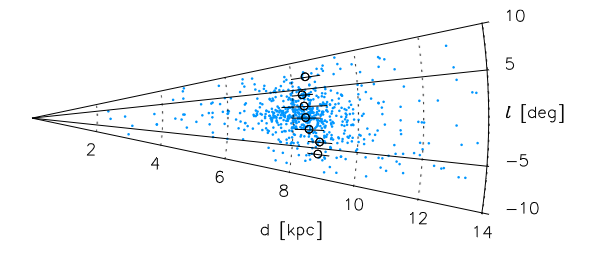

**Σχήμα 2.** Κηφείδες αστέρες στο γαλαξιακό επίπεδο ($b=0$ deg) εντός 14 kpc από εμάς (Πίστωση εικόνας: Braga et al., A&A 619, A51 (2018)).

Χρήσιμοι σύνδεσμοι python: 
1. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html 
2. https://numpy.org/doc/stable/reference/generated/numpy.isnan.html 
3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
4. https://numpy.org/doc/stable/reference/generated/numpy.histogram.html 
5. https://matplotlib.org/stable/users/explain/colors/colormaps.html